# LOADING THE DATA

In [9]:
import numpy as np
import pandas as pd
from google.colab import drive

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, cv

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
import datetime
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 6    

drive.mount('/content/drive/')
sns.set()



Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/train.csv',index_col="tripid")
test  = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/test.csv',index_col="tripid")
sub =  pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/sample_submission.csv',index_col="tripid")

In [11]:
train

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


In [12]:
test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79


In [13]:
print(sub.info())
print(train.info())
print(train['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   prediction  8576 non-null   int64
dtypes: int64(1)
memory usage: 134.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16974 non-null  float64
 1   duration                   16974 non-null  float64
 2   meter_waiting              16974 non-null  float64
 3   meter_waiting_fare         16974 non-null  float64
 4   meter_waiting_till_pickup  16974 non-null  float64
 5   pickup_time                17176 non-null  object 
 6   drop_time                  17176 non-null  object 
 7   pick_lat                   17176 non-null  float64
 8   pick_lon                   17176 

In [14]:
cleanup_label = {"label":     {'correct': '1' , 'incorrect': '0'}}
train.replace(cleanup_label, inplace=True)
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 
print(train['label'].value_counts())

train

1    15495
0     1681
Name: label, dtype: int64


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1


# Data Preprocessing

## Create Dataset

In [15]:
frames = [train, test]
dataset = pd.concat(frames)
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1.0
189125358,10.5,791.0,47.0,0.00000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1.0
189125719,10.5,1087.0,80.0,0.00000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1.0
189127273,10.5,598.0,271.0,15.66380,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.0
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,NaN
222857785,10.5,1378.0,80.0,0.00000,125.0,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,NaN
222858416,10.5,418.0,56.0,3.28440,93.0,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,NaN


In [16]:
dataset = dataset.drop_duplicates(keep='first')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            25547 non-null  float64
 1   duration                   25547 non-null  float64
 2   meter_waiting              25547 non-null  float64
 3   meter_waiting_fare         25547 non-null  float64
 4   meter_waiting_till_pickup  25547 non-null  float64
 5   pickup_time                25748 non-null  object 
 6   drop_time                  25748 non-null  object 
 7   pick_lat                   25748 non-null  float64
 8   pick_lon                   25748 non-null  float64
 9   drop_lat                   25748 non-null  float64
 10  drop_lon                   25748 non-null  float64
 11  fare                       25611 non-null  float64
 12  label                      17172 non-null  float64
dtypes: float64(11), object(2)
memory u

In [0]:
## handle NaN values
#dataset = dataset.fillna(0)
#dataset

##  Handle NaN - removed

In [18]:
dataset[dataset['fare'].isnull()]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189157607,10.5,2956.0,1686.0,97.4508,29.0,11/1/2019 8:40,11/1/2019 9:21,6.92109,79.8547,6.94120,79.8588,NaN,0.0
189164806,10.5,3549.0,2689.0,146.9854,69.0,11/1/2019 9:16,11/1/2019 9:29,6.91657,79.8593,6.89258,79.8554,NaN,0.0
189164831,NaN,NaN,NaN,NaN,NaN,11/1/2019 9:17,11/1/2019 9:25,7.27586,80.6136,7.28810,80.6319,NaN,0.0
190066074,NaN,NaN,NaN,NaN,NaN,11/5/2019 16:49,11/5/2019 17:01,7.48201,80.3580,7.50463,80.3510,NaN,0.0
190111701,NaN,NaN,NaN,NaN,NaN,11/5/2019 21:13,11/5/2019 21:15,7.03357,79.9238,7.03365,79.9238,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213449192,NaN,NaN,NaN,NaN,NaN,1/30/2020 22:52,1/30/2020 23:05,6.88183,79.8577,6.84729,79.8734,NaN,0.0
213510465,NaN,NaN,NaN,NaN,NaN,1/31/2020 10:03,1/31/2020 10:04,6.92600,79.8681,6.92596,79.8679,NaN,0.0
213538831,NaN,NaN,NaN,NaN,NaN,1/31/2020 11:53,1/31/2020 13:09,6.70807,79.9125,6.70815,79.9127,NaN,0.0


In [19]:
dataset.iloc[:,[0,1,2,3,4,11]]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare
tripid,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,270.32
189125358,10.5,791.0,47.0,0.00000,134.0,197.85
189125719,10.5,1087.0,80.0,0.00000,61.0,301.64
189127273,10.5,598.0,271.0,15.66380,68.0,82.30
189128020,NaN,NaN,NaN,NaN,NaN,358.39
...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,388.48
222857785,10.5,1378.0,80.0,0.00000,125.0,379.85
222858416,10.5,418.0,56.0,3.28440,93.0,112.79


In [0]:
#imputer = KNNImputer(n_neighbors=5,weights='uniform')
#dataset.iloc[:,[0,1,2,3,4,11]] = imputer.fit_transform(dataset.iloc[:,[0,1,2,3,4,11]])

In [21]:
dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

In [22]:
dataset.isna().sum()

additional_fare               201
duration                      201
meter_waiting                 201
meter_waiting_fare            201
meter_waiting_till_pickup     201
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                          137
label                        8576
dtype: int64

In [23]:
dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

# Feature Engineering

## Calculate Distance

In [0]:
#train_distance_dict = {}

#for ind in dataset.index:
 # pickup_lat = dataset['pick_lat'][ind]
  #pickup_long = dataset['pick_lon'][ind]
  #drop_lat = dataset['drop_lat'][ind]
  #drop_long = dataset['drop_lon'][ind]
  #coords_1 = (pickup_lat, pickup_long)
  #coords_2 = (drop_lat, drop_long)
  #distance = geopy.distance.vincenty(coords_1, coords_2).km
  #train_distance_dict[ind] = distance

#dataset['distance_val'] = dataset.index.to_series().map(train_distance_dict)

In [0]:
import numpy as np # linear algebra
import math as math_stl

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km
    dlat = math_stl.radians(lat2 - lat1)
    dlon = math_stl.radians(lon2 - lon1)
    a = math_stl.sin(dlat / 2) * math_stl.sin(dlat / 2) + math_stl.cos(math_stl.radians(lat1)) * math_stl.cos(math_stl.radians(lat2)) * math_stl.sin(dlon / 2) * math_stl.sin(dlon / 2)
    c = 2 * math_stl.atan2(math_stl.sqrt(a), math_stl.sqrt(1 - a))
    d = radius * c
    return d

In [26]:
dataset['distance'] = 0.0
#test_data['distance'] = 0.0

for index, row in dataset.iterrows():
    dataset.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])

#for index, row in test_data.iterrows():
    #dataset.at[index, 'distance'] = haversine_distance(row['pick_lat'], row['pick_lon'], row['drop_lat'], row['drop_lon'])
    
dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance
tripid,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782


## Date and Time

In [27]:
pickup_date_time = dataset[["pickup_time"]]
print("pickup_date_time.shape", pickup_date_time.shape)


pickup_date_time.shape (25748, 1)


In [28]:
drop_date_time = dataset[["drop_time"]]
print("drop_date_time.shape", drop_date_time.shape)


drop_date_time.shape (25748, 1)


In [29]:
dataset['pickup_time'] = dataset['pickup_time'].astype('datetime64[ns]')
dataset['drop_time'] = dataset['drop_time'].astype('datetime64[ns]')


dataset['year'] = dataset.pickup_time.dt.year

dataset['month'] = dataset.pickup_time.dt.month

dataset['day'] =dataset.pickup_time.dt.day

dataset['pickup_hour'] = dataset.pickup_time.dt.hour

dataset['pickup_min'] = dataset.pickup_time.dt.minute

dataset['drop_hour'] = dataset.drop_time.dt.hour

dataset['drop_min'] = dataset.drop_time.dt.minute

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
# Monday is 0 and Sunday is 6.
date_name_dict = {}
for ind in dataset.index:
  year =  dataset['year'][ind].astype(np.int64)
  month =  dataset['month'][ind].astype(np.int64)
  day =  dataset['day'][ind].astype(np.int64)
  date_obj = datetime.date(year,month,day)
  date_Day  = date_obj.weekday()
  date_name_dict[ind] = date_Day

In [31]:
dataset['weekday'] = dataset.index.to_series().map(date_name_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
dataset['weekday'].value_counts()

4    3959
3    3862
5    3792
2    3742
1    3680
0    3675
6    3038
Name: weekday, dtype: int64

## location clustering using KMean(elbow curve)

### pickup clustering

In [33]:
pickup_location = dataset[['pick_lat','pick_lon']]   #pick_lat	pick_lon
drop_location = dataset[['drop_lat','drop_lon']]  #drop_lat	drop_lon
pickup_location

,pick_lat,pick_lon
tripid,,
189123628,6.86252,79.8993
189125358,6.88589,79.8984
189125719,6.90839,79.8651
189127273,6.92570,79.8895
189128020,6.87441,79.8615
...,...,...
222856243,6.85103,79.9567
222857785,6.91293,79.9656
222858416,6.85718,79.9081


In [34]:
dataset.columns[7:9]

Index(['pick_lat', 'pick_lon'], dtype='object')

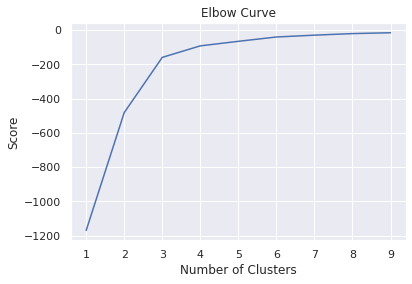

In [35]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['pick_lat']]
X_axis = dataset[['pick_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [36]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(pickup_location[pickup_location.columns[0:2]]) # Compute k-means clustering.
dataset['pick_location_cluster'] = kmeans.fit_predict(pickup_location[pickup_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(pickup_location[pickup_location.columns[0:2]]) # Labels of each point
print(dataset['pick_location_cluster'].value_counts())
dataset

0    21742
1     3554
2      452
Name: pick_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,2019,11,1,0,20,0,34,4,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,2019,11,1,0,56,1,9,4,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,2019,11,1,1,8,1,26,4,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,2019,11,1,2,27,2,37,4,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,2019,11,1,3,34,3,51,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,2020,3,16,21,28,21,56,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,2020,3,16,21,59,22,22,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,2020,3,16,22,2,22,9,0,0


### drop clustering

In [37]:
dataset.columns[9:11]

Index(['drop_lat', 'drop_lon'], dtype='object')

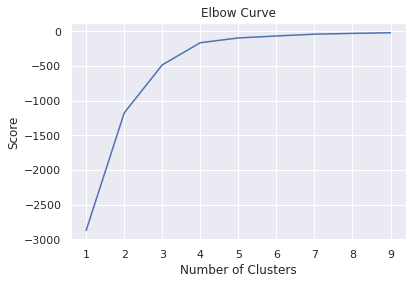

In [38]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['drop_lat']]
X_axis = dataset[['drop_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [39]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(drop_location[drop_location.columns[0:2]]) # Compute k-means clustering.
dataset['drop_location_cluster'] = kmeans.fit_predict(drop_location[drop_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(drop_location[drop_location.columns[0:2]]) # Labels of each point
print(dataset['drop_location_cluster'].value_counts())
dataset

0    22191
2     3556
1        1
Name: drop_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,2019,11,1,0,20,0,34,4,0,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,2019,11,1,0,56,1,9,4,0,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,2019,11,1,1,8,1,26,4,0,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,2019,11,1,2,27,2,37,4,0,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,2019,11,1,3,34,3,51,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,2020,3,16,21,28,21,56,0,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,2020,3,16,21,59,22,22,0,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,2020,3,16,22,2,22,9,0,0,0


## New Features

In [0]:
#dataset['add_fare + meter_wait_fare'] = dataset['additional_fare']+dataset['meter_waiting_fare']
#dataset['meter_waiting + meter_waiting_till_pickup'] = dataset['meter_waiting'] + dataset['meter_waiting_till_pickup']
#dataset['duration + meter_waiting_till_pickup + meter_waiting'] = dataset['duration'] + dataset['meter_waiting_till_pickup'] + dataset['meter_waiting']
#dataset['distance_val / fare'] = dataset['distance_val'] / dataset['fare']
#dataset['distance_val / duration'] = dataset['distance_val'] / dataset['duration']
#dataset['additional_fare / distance'] = dataset['additional_fare'] / dataset['distance_val']
#dataset['additional_fare / duration'] = dataset['additional_fare'] / dataset['duration']


In [41]:
dataset.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster'],
      dtype='object')

In [42]:
dataset['(fare - waiting_fare) / distance'] = (dataset['fare']-dataset['meter_waiting_fare']) / dataset['distance']
dataset['additional_fare / distance'] = dataset['additional_fare'] / dataset['distance']
dataset['(fare - waiting_fare) / (duration - meter_waiting)'] = (dataset['fare'] - 
                                                                 dataset['meter_waiting_fare']) / (dataset['duration'] - dataset['meter_waiting'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
# additional_fare / distance  -done
# (fare - waiting_fare) / distance
# (fare - waiting_fare) / (duration - meter_waiting)

In [44]:

dataset['distance / (duration - meter_waiting)'] = dataset['distance'] / (dataset['duration'] - dataset['meter_waiting'])
dataset['meter_waiting / duration'] = dataset['meter_waiting'] / dataset['duration']


dataset['additional_fare / fare + additional_fare'] = dataset['additional_fare'] / (dataset['fare'] + dataset['additional_fare'])

dataset['(duration-meter_waiting)/fare'] = (dataset['duration'] - dataset['meter_waiting'])/dataset['fare']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [0]:

# distance / (duration - meter_waiting)
# meter_waiting / duration
# additional_fare / fare+additional_fare
# (duration-meter_waiting)/fare

## Categorize Continuous Classes

In [46]:

dataset['additional_fare'].value_counts()

10.50       22258
5.00         1699
30.50         538
40.50         372
60.50         277
110.50        112
21.00         102
80.50          38
25.00          21
55.00          21
11.00          21
35.00          17
0.00           16
85.50          15
20.50          14
105.00          5
81.00           4
75.00           3
210.50          2
80.00           2
221.00          2
450.82          1
111.00          1
70.50           1
91.50           1
160.50          1
10.00           1
12795.03        1
61.00           1
Name: additional_fare, dtype: int64

In [47]:
dataset['additional_fare'] = dataset.additional_fare.astype("category").cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
dataset['additional_fare'].value_counts()

 3     22258
 1      1699
 8       538
 10      372
 12      277
-1       201
 22      112
 6       102
 17       38
 7        21
 4        21
 11       21
 9        17
 0        16
 19       15
 5        14
 21        5
 18        4
 15        3
 25        2
 26        2
 16        2
 23        1
 24        1
 20        1
 27        1
 28        1
 2         1
 13        1
 14        1
Name: additional_fare, dtype: int64

In [49]:
dataset['year'].value_counts()

2020    14399
2019    11349
Name: year, dtype: int64

In [50]:
dataset['year'] = dataset.year.astype("category").cat.codes
dataset['year'].value_counts()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    14399
0    11349
Name: year, dtype: int64

In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 31 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   additional_fare                                     25748 non-null  int8          
 1   duration                                            25547 non-null  float64       
 2   meter_waiting                                       25547 non-null  float64       
 3   meter_waiting_fare                                  25547 non-null  float64       
 4   meter_waiting_till_pickup                           25547 non-null  float64       
 5   pickup_time                                         25748 non-null  datetime64[ns]
 6   drop_time                                           25748 non-null  datetime64[ns]
 7   pick_lat                                            25748 non-null  float64       

In [0]:

#Winter - 1 December	28 February
#Spring - 1 March	31 May
#Summer - 1 June	31 August
#Autumn - 1 September	30 November

#peak hours of traffic congestion  -  6a. m to 9.30a.m and 4.30p.m to 7.30p.m
#heavy traffic congestion - afternoon 1.30p.m to 2.30p.m also identify

#weekdays and weekends



In [0]:
#season = ('Winter','Spring','Summer','Autumn')
#Spring - 0
#Summer - 1
#Autumn - 2
#Winter - 3
#season_name_dict = {}
#for ind in dataset.index:
  #month =  dataset['month'][ind].astype(np.int64)
  #if( 2 < dataset['month'][ind] < 6):
    #season_name_dict[ind] = 0
  #elif( 5 < dataset['month'][ind] < 9):
    #season_name_dict[ind] = 1
  #elif( 8 < dataset['month'][ind] < 12):
    #season_name_dict[ind] = 2
  #else:
    #season_name_dict[ind] = 3
    


In [0]:
#dataset['season'] = dataset.index.to_series().map(season_name_dict)

In [0]:
#weekday - 0 , weekend - 1
#in dataset - Monday is 0 and Sunday is 6.
#day_cat = {}
#for ind in dataset.index:
  #day =  dataset['weekday'][ind].astype(np.int64)
  #if(day==5 or day==6):
    #day_cat[ind] = 1
  #else:
    #day_cat[ind] = 0

#dataset['day_category'] = dataset.index.to_series().map(day_cat)



## Normalize

In [0]:
from sklearn.preprocessing import Normalizer




In [57]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [0]:
#arr1 = dataset.duration.to_numpy()
#arr2 = dataset.meter_waiting.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr4 = dataset.meter_waiting_till_pickup.to_numpy()
#arr5 = dataset.fare.to_numpy()
#arr6 = dataset.distance_val.to_numpy()
#arr = [arr1,arr2,arr3,arr4,arr5,arr6]
#transformer = Normalizer().fit(arr) 
#arr = transformer.transform(arr)

In [0]:
#a = arr[0]
#b = arr[1]
#c = arr[2]
#d = arr[3]
#e = arr[4]
#f = arr[5]
#index=[]
#for ind in dataset.index:
  #index.append(ind) 

#df1 = pd.DataFrame(data=b, index=index, columns=["duration"])
#df2 = pd.DataFrame(data=b, index=index, columns=["meter_waiting"])
#df3 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_fare"])
#df4 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_till_pickup"])
#df5 = pd.DataFrame(data=b, index=index, columns=["fare"])
#df6 = pd.DataFrame(data=b, index=index, columns=["distance_val"])

#dataset['duration'] = df1
#dataset['meter_waiting'] = df2
#dataset['meter_waiting_fare'] = df3
#dataset['meter_waiting_till_pickup'] = df4
#dataset['fare'] = df5
#dataset['distance_val'] = df6

#dataset

# Feature visualization

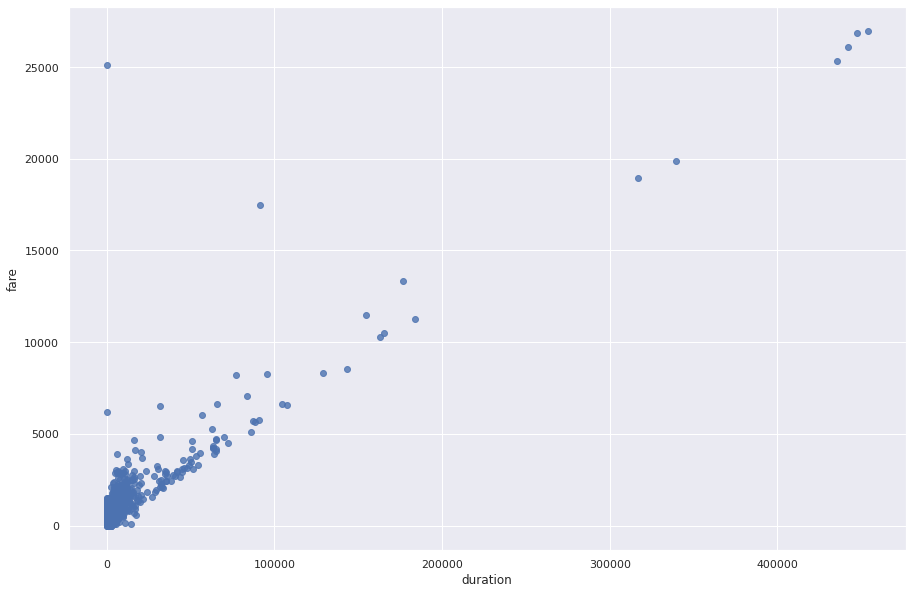

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



In [0]:
#dataset['mul_duration'] = dataset.duration * dataset.duration

#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="mul_duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



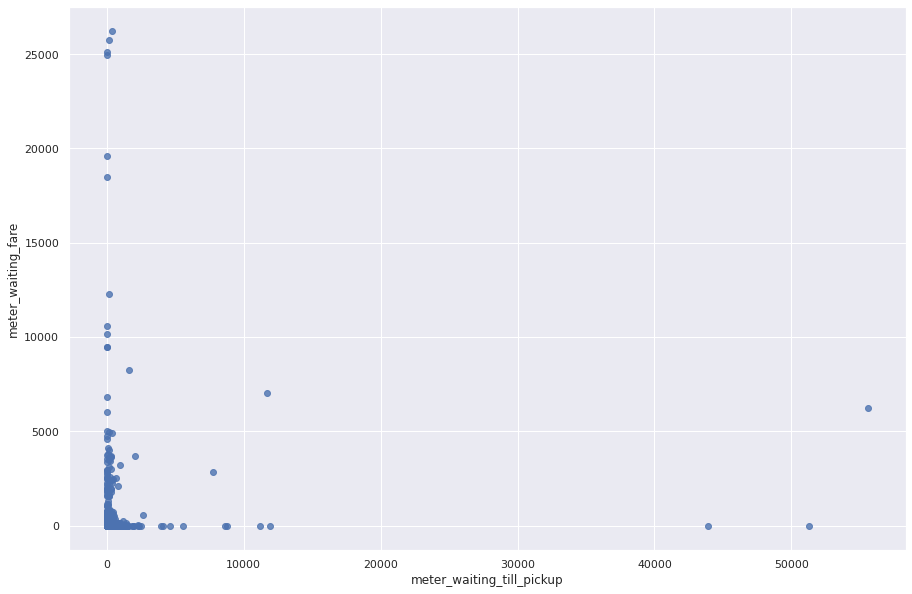

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="meter_waiting_till_pickup",y="meter_waiting_fare",fit_reg=False,ci=None,truncate=True,data=dataset)


In [0]:
#dataset['mul_meter_waiting'] = dataset.meter_waiting * dataset.meter_waiting
#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="meter_waiting_fare",y="mul_meter_waiting",fit_reg=False,ci=None,truncate=True,data=dataset)

In [0]:
#fig = plt.figure(figsize=(6, 6))
#plt.scatter(x="duration",y="actual_fare",
          # linewidths=1, alpha=.7,
         #  edgecolor='k',
         #  s = 200,
          # c='year',data=dataset)
#plt.show()

# Split dataset to train and test

In [0]:
test = dataset.loc[213284604:222860703]
test = test.drop(['label'], axis=1)



In [0]:
train = dataset.loc[189123628:213817296]
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 


In [67]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [68]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


In [69]:
dataset.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare'],
      dtype='object')

# Setup data to train model

In [70]:
train_features = train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]
print(train_features.info())
train_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 28 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   additional_fare                                     17172 non-null  int8   
 1   duration                                            16971 non-null  float64
 2   meter_waiting                                       16971 non-null  float64
 3   meter_waiting_fare                                  16971 non-null  float64
 4   meter_waiting_till_pickup                           16971 non-null  float64
 5   pick_lat                                            17172 non-null  float64
 6   pick_lon                                            17172 non-null  float64
 7   drop_lat                                            17172 non-null  float64
 8   drop_lon                                            17172 non-nu

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,3,834.0,56.0,0.0000,64.0,6.86252,79.8993,6.90330,79.8783,270.32,5.092770,0,11,1,0,20,0,34,4,0,0,53.079170,2.061746,0.347455,0.006546,0.067146,0.037390,2.878070
189125358,3,791.0,47.0,0.0000,134.0,6.88589,79.8984,6.91373,79.8923,197.85,3.168058,0,11,1,0,56,1,9,4,0,0,62.451516,3.314334,0.265927,0.004258,0.059418,0.050396,3.760425
189125719,3,1087.0,80.0,0.0000,61.0,6.90839,79.8651,6.93669,79.9146,301.64,6.305395,0,11,1,1,8,1,26,4,0,0,47.838398,1.665241,0.299543,0.006262,0.073597,0.033639,3.338417
189127273,3,598.0,271.0,15.6638,68.0,6.92570,79.8895,6.92748,79.8971,82.30,0.861946,0,11,1,2,27,2,37,4,0,0,77.309009,12.181736,0.203780,0.002636,0.453177,0.113147,3.973269
189128020,-1,NaN,NaN,NaN,NaN,6.87441,79.8615,6.84478,79.9290,358.39,8.147782,0,11,1,3,34,3,51,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,3,838.0,93.0,5.4219,451.0,7.29073,80.6367,7.28891,80.6557,198.26,2.105376,1,1,31,22,7,22,21,4,1,2,91.593204,4.987234,0.258843,0.002826,0.110979,0.050297,3.757692
213812756,3,2151.0,428.0,0.0000,39.0,6.90569,79.8516,6.95089,79.9389,581.23,10.868377,1,1,31,23,7,23,43,4,0,0,53.479005,0.966106,0.337336,0.006308,0.198977,0.017745,2.964403
213813930,3,263.0,9.0,0.0000,110.0,7.09210,79.9000,7.10135,79.9017,76.20,1.045518,1,1,31,23,21,23,25,4,0,0,72.882500,10.042864,0.300000,0.004116,0.034221,0.121107,3.333333


In [71]:
train_lable = train[['label']]
print(train_lable.info())
train_lable

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   17172 non-null  int64
dtypes: int64(1)
memory usage: 268.3 KB
None


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1
...,...
213803193,1
213812756,1
213813930,1


In [72]:
test_features = test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup','pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'distance', 'year',
       'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour', 'drop_min',
       'weekday', 'pick_location_cluster', 'drop_location_cluster',
       '(fare - waiting_fare) / distance', 'additional_fare / distance',
       '(fare - waiting_fare) / (duration - meter_waiting)',
       'distance / (duration - meter_waiting)', 'meter_waiting / duration',
       'additional_fare / fare + additional_fare',
       '(duration-meter_waiting)/fare']]

print(test_features.info())
test_features


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 28 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   additional_fare                                     8576 non-null   int8   
 1   duration                                            8576 non-null   float64
 2   meter_waiting                                       8576 non-null   float64
 3   meter_waiting_fare                                  8576 non-null   float64
 4   meter_waiting_till_pickup                           8576 non-null   float64
 5   pick_lat                                            8576 non-null   float64
 6   pick_lon                                            8576 non-null   float64
 7   drop_lat                                            8576 non-null   float64
 8   drop_lon                                            8576 non-null

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,distance,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,(fare - waiting_fare) / distance,additional_fare / distance,(fare - waiting_fare) / (duration - meter_waiting),distance / (duration - meter_waiting),meter_waiting / duration,additional_fare / fare + additional_fare,(duration-meter_waiting)/fare
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
213284604,3,924.0,42.0,2.44860,148.0,6.83454,79.8750,6.77490,79.8840,289.27,6.705702,1,2,1,0,38,0,53,5,0,0,42.772765,1.565832,0.325194,0.007603,0.045455,0.035027,3.049055
213286352,3,4249.0,20.0,0.00000,91.0,6.91168,79.8723,6.55091,79.9706,1912.70,41.558513,1,2,1,1,2,2,13,5,0,0,46.024264,0.252656,0.452282,0.009827,0.004707,0.005460,2.211011
213293973,3,1552.0,255.0,2.65880,23.0,6.92145,79.8478,6.90539,79.8989,394.00,5.916678,1,2,1,5,2,5,28,5,0,0,66.142047,1.774644,0.301728,0.004562,0.164304,0.025958,3.291878
213294622,3,462.0,16.0,0.00000,198.0,6.77433,79.9416,6.80401,79.9407,154.32,3.301761,1,2,1,5,30,5,38,5,0,0,46.738692,3.180121,0.346009,0.007403,0.034632,0.063706,2.890098
213298687,3,814.0,392.0,12.36920,69.0,6.97968,79.9130,6.98875,79.8914,147.47,2.588542,1,2,1,7,0,7,14,5,0,0,52.191855,4.056338,0.320144,0.006134,0.481572,0.066468,2.861599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,3,1723.0,429.0,24.83332,3.0,6.85103,79.9567,6.85588,79.9214,388.48,3.934272,1,3,16,21,28,21,56,0,0,0,92.430498,2.668855,0.281025,0.003040,0.248984,0.026317,3.330931
222857785,3,1378.0,80.0,0.00000,125.0,6.91293,79.9656,6.92112,79.8980,379.85,7.517433,1,3,16,21,59,22,22,0,0,0,50.529219,1.396753,0.292643,0.005792,0.058055,0.026899,3.417138
222858416,3,418.0,56.0,3.28440,93.0,6.85718,79.9081,6.83868,79.9083,112.79,2.057225,1,3,16,22,2,22,9,0,0,0,53.229773,5.103964,0.302502,0.005683,0.133971,0.085165,3.209504


# Model

## CAT Boost

In [0]:
convert_dict2 = {'additional_fare': 'int64'}
train_features = train_features.astype(convert_dict2) 
convert_dict2 = {'additional_fare': 'int64'}
test_features = test_features.astype(convert_dict2) 





## Evaluation

In [74]:
rnd_state = 42

# make train val split to try out-of-the-box
X_train, X_val, y_train, y_val = train_test_split(train_features, train_lable, test_size=0.2, random_state=rnd_state)
categorical_features_indices = np.where(train_features.dtypes != np.float)[0]


clf = CatBoostClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_val, y_val))
#Learning rate set to 0.031537

Learning rate set to 0.031537
0:	learn: 0.6530723	total: 64.2ms	remaining: 1m 4s
1:	learn: 0.6149551	total: 78.5ms	remaining: 39.2s
2:	learn: 0.5760799	total: 92.9ms	remaining: 30.9s
3:	learn: 0.5414496	total: 107ms	remaining: 26.7s
4:	learn: 0.5103609	total: 121ms	remaining: 24.2s
5:	learn: 0.4815047	total: 136ms	remaining: 22.5s
6:	learn: 0.4525913	total: 150ms	remaining: 21.3s
7:	learn: 0.4290209	total: 165ms	remaining: 20.4s
8:	learn: 0.4052942	total: 179ms	remaining: 19.7s
9:	learn: 0.3848371	total: 193ms	remaining: 19.1s
10:	learn: 0.3665025	total: 213ms	remaining: 19.2s
11:	learn: 0.3502185	total: 228ms	remaining: 18.8s
12:	learn: 0.3355908	total: 243ms	remaining: 18.4s
13:	learn: 0.3207240	total: 257ms	remaining: 18.1s
14:	learn: 0.3081221	total: 271ms	remaining: 17.8s
15:	learn: 0.2959030	total: 286ms	remaining: 17.6s
16:	learn: 0.2849737	total: 300ms	remaining: 17.3s
17:	learn: 0.2742239	total: 315ms	remaining: 17.2s
18:	learn: 0.2653082	total: 329ms	remaining: 17s
19:	learn:

## Train and Predict

In [75]:
# Submission 1: catboost submission with all training data and early stopping on Accuracy

clf_od = CatBoostClassifier()
clf_od.fit(train_features, train_lable)


prediction = clf_od.predict(test_features).astype('int')

Learning rate set to 0.03469
0:	learn: 0.6437020	total: 16.6ms	remaining: 16.5s
1:	learn: 0.6014437	total: 33ms	remaining: 16.5s
2:	learn: 0.5600339	total: 48.9ms	remaining: 16.2s
3:	learn: 0.5213302	total: 64.9ms	remaining: 16.2s
4:	learn: 0.4882367	total: 81.3ms	remaining: 16.2s
5:	learn: 0.4590226	total: 97.5ms	remaining: 16.1s
6:	learn: 0.4296559	total: 113ms	remaining: 16.1s
7:	learn: 0.4055943	total: 130ms	remaining: 16.1s
8:	learn: 0.3815637	total: 146ms	remaining: 16s
9:	learn: 0.3592012	total: 162ms	remaining: 16s
10:	learn: 0.3412820	total: 178ms	remaining: 16s
11:	learn: 0.3235217	total: 205ms	remaining: 16.9s
12:	learn: 0.3102635	total: 221ms	remaining: 16.8s
13:	learn: 0.2966448	total: 237ms	remaining: 16.7s
14:	learn: 0.2850746	total: 253ms	remaining: 16.6s
15:	learn: 0.2753502	total: 269ms	remaining: 16.6s
16:	learn: 0.2655914	total: 285ms	remaining: 16.5s
17:	learn: 0.2554667	total: 301ms	remaining: 16.4s
18:	learn: 0.2461707	total: 317ms	remaining: 16.3s
19:	learn: 0.2

In [76]:

index=[]
for ind in test_features.index:
  index.append(ind)

test_features['tripid'] = index

submission = pd.DataFrame({
        "tripid": test_features["tripid"],
        "prediction": prediction
    })
submission = submission.drop(['tripid'],1)
test_features = test_features.drop(['tripid'],1)
print(submission['prediction'].value_counts())
submission

1    8149
0     427
Name: prediction, dtype: int64


,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [0]:
DATA_PATH = '/content/drive/My Drive/Data Sets/ML data/output'
sub_path = DATA_PATH + 'day_before_last_cat_new_features.csv'
submission.to_csv(sub_path, index=True)
print('Completed!')

Completed!
